<a href="https://colab.research.google.com/github/DaviCMaciel/LIT/blob/main/LIT_LBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tarefa 3:
- Extrator LBP, dataset livre (kaggle)
- Classificadores KNN e SVM
- Resultados:
- Matriz de confusão na acurácia
- Gráfico boxplot de Acurácia, comparando os números dois classificadores.

In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
import seaborn
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
!pip install kaggle opencv-python-headless scikit-learn matplotlib

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhshahane/barkvn50")

print("Path to dataset files:", path)

100%|██████████| 176M/176M [00:03<00:00, 59.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saurabhshahane/barkvn50/versions/1


In [ ]:
!ls {path}


BarkVN-50


In [ ]:
def load_dataset_recursive(path, classes):
    data, labels = [], []

    # Caminhando pelos diretórios e arquivos
    for root, dirs, files in os.walk(path):
        for file in files:
            # Verificando a extensão da imagem
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    # Verificar se a classe (diretório) está na lista de classes
                    class_name = os.path.basename(root)
                    if class_name in classes:
                        img = cv2.resize(img, (128, 128))
                        data.append(img)
                        labels.append(class_name)

    return np.array(data), np.array(labels)

# Classes específicas que você deseja incluir
classes = ['Acacia', 'Cedrus', 'Eucalyptus', 'Musa', 'Wrightia']

# Caminho para o dataset
dataset_path = '/root/.cache/kagglehub/datasets/saurabhshahane/barkvn50/versions/1'

# Carregar dataset
data, labels = load_dataset_recursive(dataset_path, classes)

# Exibir os dados carregados e as classes
print(f"Total de imagens: {len(data)}")
print(f"Dimensões das imagens: {data.shape}")
print(f"Classes únicas: {np.unique(labels)}")

Total de imagens: 551
Dimensões das imagens: (551, 128, 128)
Classes únicas: ['Acacia' 'Cedrus' 'Eucalyptus' 'Musa' 'Wrightia']


In [ ]:
def LBP(imagens, raio = 1, n_pontos = 8):
  features = []
  for img in imagens:
        lbp = local_binary_pattern(img, n_pontos, raio, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_pontos + 3), range=(0, n_pontos + 2))
        hist = hist.astype("float")
        hist /= hist.sum()
        features.append(hist)
  return np.array(features)


In [ ]:
le = LabelEncoder()
X = LBP(data)
y = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Grid Search para KNN
param_grid = {'n_neighbors': list(range(1, 31))}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
print(f"Melhor valor de k: {best_k}")

Melhor valor de k: 14


In [ ]:
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=best_k),
    "SVM": SVC(kernel="linear"),
}

results = {}
for name, model in classifiers.items():
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    acc = (metrics.accuracy_score(y_test, y_pred) * 100)
    results[name] = acc


results

{'KNN': 73.87387387387388, 'SVM': 72.97297297297297}

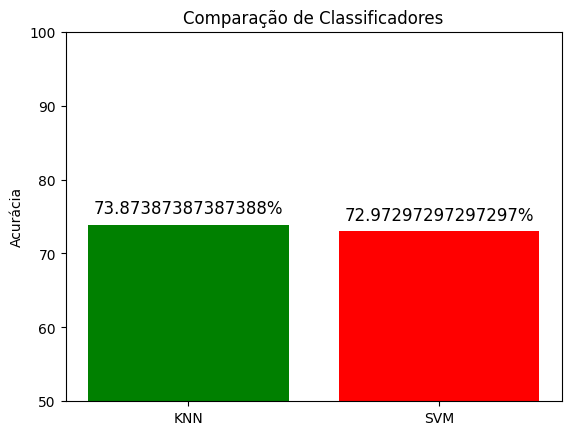

In [ ]:
plt.bar(results.keys(), results.values(), color=['green', 'red'])
for i, (key, value) in enumerate(results.items()):
    plt.text(i, value + 1, f'{value}%', ha='center', va='bottom', fontsize=12)
plt.title("Comparação de Classificadores")
plt.ylabel("Acurácia")
plt.ylim(50, 100)
plt.show()

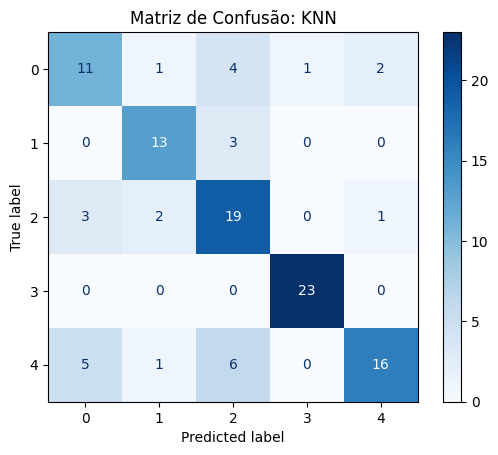

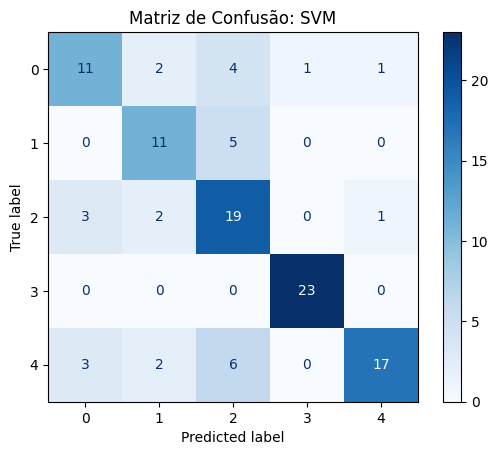

In [ ]:
for name, model in classifiers.items():
    metrics.ConfusionMatrixDisplay.from_estimator(model, X_test_scaled if name == 'SVM' else X_test, y_test, cmap='Blues')
    plt.title(f"Matriz de Confusão: {name}")
    plt.show()

In [ ]:
radius_values = [1, 2, 3, 5, 7, 10, 13, 17, 21, 26, 31, 37, 43, 50]
N = [8, 16, 24, 32, 40, 48, 56, 64, 72, 80]
acc_raio, acc_N = [], []

X2_train, X2_test, y2_train, y2_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [ ]:
for radius in radius_values:
    lbp_train = LBP(X2_train, raio = radius, n_pontos= 8)
    lbp_test = LBP(X2_test, raio = radius, n_pontos= 8)
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(lbp_train, y2_train)
    acc = (metrics.accuracy_score(y_test, knn.predict(lbp_test)) * 100)
    acc_raio.append(acc)

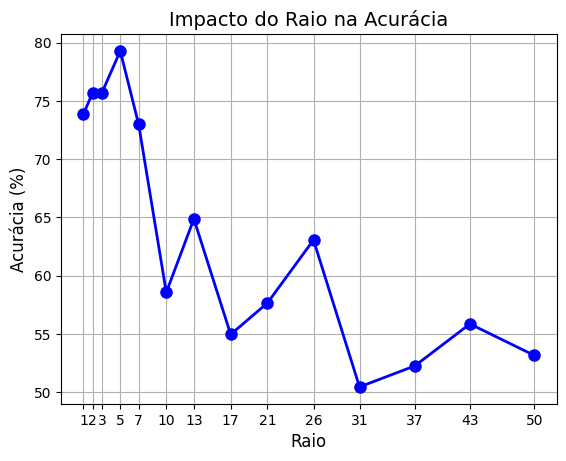

In [ ]:
plt.plot(radius_values, acc_raio, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Adicionando rótulos e título
plt.title("Impacto do Raio na Acurácia", fontsize=14)
plt.xlabel("Raio", fontsize=12)
plt.ylabel("Acurácia (%)", fontsize=12)
plt.xticks(radius_values)  # Para garantir que os valores de raio apareçam como ticks
plt.grid(True)

# Exibindo o gráfico
plt.show()

In [ ]:
for n in N:
    lbp_train = LBP(X2_train, raio = 5, n_pontos= n)
    lbp_test = LBP(X2_test, raio = 5, n_pontos= n)
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(lbp_train, y2_train)
    acc = (metrics.accuracy_score(y_test, knn.predict(lbp_test)) * 100)
    acc_N.append(acc)

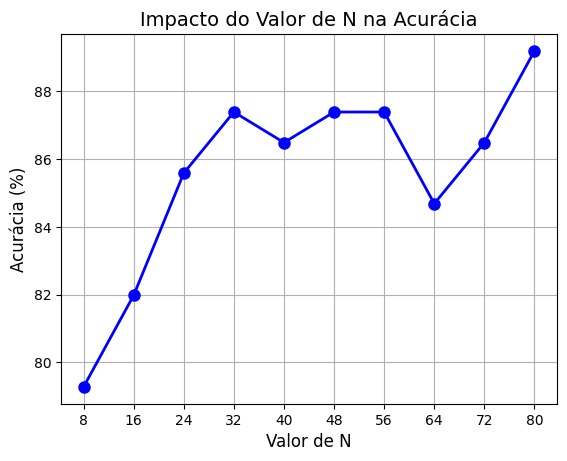

In [ ]:
plt.plot(N, acc_N, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Adicionando rótulos e título
plt.title("Impacto do Valor de N na Acurácia", fontsize=14)
plt.xlabel("Valor de N", fontsize=12)
plt.ylabel("Acurácia (%)", fontsize=12)
plt.xticks(N)  # Para garantir que os valores de raio apareçam como ticks
plt.grid(True)

# Exibindo o gráfico
plt.show()

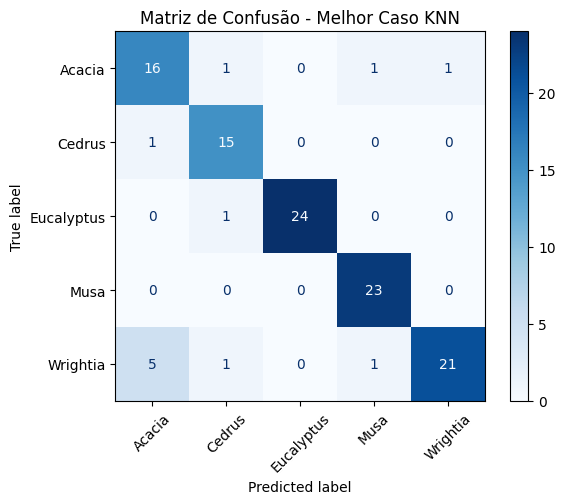

In [ ]:
# Melhor caso KNN
X3_train, X3_test, y3_train, y3_test = train_test_split(data, y, test_size=0.2, random_state=42)
lbp_train = LBP(X3_train, raio=5, n_pontos=80)
lbp_test = LBP(X3_test, raio=5, n_pontos=80)

# Treina e prediz com KNN
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(lbp_train, y3_train)
y_pred = knn.predict(lbp_test)

# Obtém os nomes das classes
class_labels = le.classes_

# Gera a matriz de confusão
metrics.ConfusionMatrixDisplay.from_predictions(
    y3_test, y_pred, display_labels=class_labels, cmap='Blues', xticks_rotation=45
)
plt.title("Matriz de Confusão - Melhor Caso KNN")
plt.show()

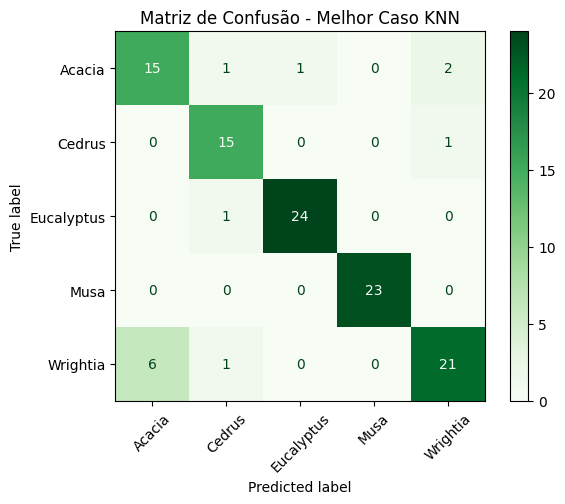

In [ ]:
# Treina e prediz com SVM
scaler = StandardScaler()
lbp_train = LBP(X3_train, raio=5, n_pontos=80)
lbp_test = LBP(X3_test, raio=5, n_pontos=80)

X3_train_scaled = scaler.fit_transform(lbp_train)
X3_test_scaled = scaler.transform(lbp_test)

svm = SVC(kernel="linear")
svm.fit(X3_train_scaled, y3_train)
y_pred2 = svm.predict(X3_test_scaled)

# Gera a matriz de confusão
metrics.ConfusionMatrixDisplay.from_predictions(
    y3_test, y_pred2, display_labels=class_labels, cmap='Greens', xticks_rotation=45
)
plt.title("Matriz de Confusão - Melhor Caso SVM")
plt.show()